# Install some libraries not included yet in python

In [1]:
pip install catboost

     |████████████████████████████████| 66.3MB 59kB/s 


In [2]:
pip install libtiff

     |████████████████████████████████| 133kB 5.2MB/s 
  Created wheel for libtiff: filename=libtiff-0.4.2-cp36-cp36m-linux_x86_64.whl size=280156 sha256=5c1c341e91879ea52574737e0e912c87801021af4f671c2d604cfbfcab12ca79
  Stored in directory: /root/.cache/pip/wheels/7c/ce/79/9c7115224f798f73bdbd2c23e06c6fa048adcca7041b9fd104
Successfully built libtiff


#Import needed libraries

In [62]:
import os
import re
import csv
import pandas as pd
import math as m
import numpy as np
import matplotlib.pyplot as plt
import pickle
import joblib
import seaborn as sns
import statistics
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import ee
import webbrowser

In [63]:
import PIL.Image as Image
import libtiff 
import tifffile as tiff
from libtiff import TIFF

In [74]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from skimage.io import imread

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [65]:
pip install catboost


In [ ]:
'''
os.chdir('C:\\Users\\Skynet\\______FDS______\\Project final')
path = os.getcwd()
path

'''

'C:\\Users\\Skynet\\______FDS______\\Project final'

# **1) MODELING PART**

### Attribute extraction from train dataset

In [22]:
file_train = "sat_train.trn"
file_test = "sat_test.tst"

Y_train = []
X_train = []

with open(file_train) as file:
    
    for i in range (1,4436,1):

        line = file.readline().split()
        Trueline = line[16:20]
        Trueline = list(map( int , Trueline))
        X_train.append(Trueline)
        Y_train.append(int(line[36]))
    
    #X e Y train go well for everything 

In [23]:
len(Y_train), len(X_train)

(4435, 4435)

In [24]:
Y_test = []
X_test = []

with open(file_test) as file:
    
    for i in range (1,2001,1):

        line = file.readline().split()
        Trueline = line[16:20]
        Trueline = list(map( int , Trueline))
        X_test.append(Trueline)
        Y_test.append(int(line[36]))
        
        
len(X_test)    

2000

## Logistic Regression 

#### OvR

In [66]:
OvR_clf = OneVsRestClassifier(LogisticRegression())
OvR_clf.fit(X_train, Y_train)

y_pred = OvR_clf.predict(X_test)

print('Accuracy of OvR Classifier: {:.3f}'.format(accuracy_score(Y_test, y_pred)))

Accuracy of OvR Classifier: 0.795


**MANUAL GRID SEARCH**


In [68]:
# define models and parameters

model = LogisticRegression( multi_class = "ovr" )
solvers = ['newton-cg', 'lbfgs', 'liblinear']

#(lbfgs) Limited-memory BFGS
#(liblinear) library for large linear classification
#(newton-cg) hessian newton method

penalty = ['l2']

#to specify norm utilized in penalization

c_values = [150,100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
#boundary distance

acc = -1 
params = []

for s in solvers:
  for c in c_values:
    ovr_model = LogisticRegression(penalty='l2', C=c, solver=s, multi_class='ovr',class_weight='balanced')
    ovr_model.fit(X_train,Y_train) #fit
    ovr_pred = ovr_model.predict(X_test)
    grid_accuracy = accuracy_score(ovr_pred,Y_test)

    if grid_accuracy> acc:
      print('temporary best accuracy: ',grid_accuracy)
      acc = grid_accuracy
      params = [s,c]

print('Best params are :', 'c:',params[1],' solver: ',params[0])


temporary best accuracy:  0.8045
temporary best accuracy:  0.805
temporary best accuracy:  0.8065
temporary best accuracy:  0.8075
Best params are : c: 100  solver:  liblinear


#### **Multiclass**

**MANUAL GRID SEARCH**


In [69]:
# define models and parameters

solvers = ['newton-cg', 'lbfgs'] #liblinear raise an error

#(lbfgs) Limited-memory BFGS
#(liblinear) library for large linear classification
#(newton-cg) hessian newton method

penalty = ['l2']

#to specify norm utilized in penalization

c_values = [150,100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
#boundary distance

acc_m = -1 
params_m = []

for s in solvers:
  for c in c_values:
    m_model = LogisticRegression(penalty='l2', C=c, solver=s, multi_class='multinomial',class_weight='balanced')
    m_model.fit(X_train,Y_train) #fit
    m_pred = m_model.predict(X_test)
    grid_accuracy_m = accuracy_score(m_pred,Y_test)

    if grid_accuracy_m> acc_m:
      print('temporary best accuracy: ',grid_accuracy_m)
      acc_m = grid_accuracy_m
      params_m = [s,c]

print('Best params are :', 'c:',params_m[1],' solver: ',params_m[0])

temporary best accuracy:  0.827
temporary best accuracy:  0.8275
temporary best accuracy:  0.8295
Best params are : c: 0.001  solver:  newton-cg


**Now we use and save the best Multiclass LR Model**

In [71]:
Multiclass_LR = LogisticRegression(penalty='l2', C=0.001, solver='newton-cg', multi_class='multinomial',class_weight='balanced')

logReg = Multiclass_LR.fit(X_train,Y_train)     #fit

pred_LG = Multiclass_LR.predict(X_test)         #predict

acc_log_reg = accuracy_score(pred_LG,Y_test)    #compute accuracy 
print('accuracy score:',acc_log_reg)

accuracy score: 0.8295


In [72]:
#save the model
joblib.dump(logReg, 'C:\\Users\\Emanuele_Fratocchi\\Desktop\\logReg.pkl')

['C:\\Users\\Emanuele_Fratocchi\\Desktop\\logReg.pkl']

**So, the best Logistic Regression Model is: Multiclass. His accuracy score is 0.8295**

# NB GNB

In [163]:
gnb = GaussianNB()

gnb.fit(X_train, Y_train)

y_pred = gnb.predict(X_test)

nb_acc = accuracy_score(Y_test, y_pred)

print('Accuracy: {:.3f}'.format(accuracy_score(Y_test, y_pred)))

Accuracy: 0.791


In [77]:
joblib.dump(gnb, 'C:\\Users\\Emanuele_Fratocchi\\Desktop\\naivebayes.pkl')

['C:\\Users\\Emanuele_Fratocchi\\Desktop\\naivebayes.pkl']

# CAT-BOOST


In [80]:
cat_features = list(range(0, len(X_train[0]))) #here we declare Categorical features 
print(cat_features)

[0, 1, 2, 3]


In [ ]:
#all params on which we are going to do hyperparametres fine tuning

depth=[3,1,2,6,4,5,7,8,9,10]
iterations = [250,100,500]
l_rate = [0.01,0.1,0.2,0.3] 
l2_leaf_reg = [1,5,3,10,100]
border_count = [5,10,20,32,50,100]


In [ ]:
#grid research of catboost parametres

grid_search_results = {}

for d in depth:
  for i in iterations:
    for l in l_rate:
      for l2 in l2_leaf_reg:
        for b in border_count:

          #model params

          par_list = [d,i,l,l2,b]
         # print(par_list)

          clf = CatBoostClassifier(
          depth = d,
          iterations=i, 
          learning_rate= l,
          l2_leaf_reg= l2,
          border_count = b,
          thread_count =4, 
          loss_function='MultiClass',
          custom_loss=['Accuracy'],
          )

          #fitting model 

          clf.fit(X_train, Y_train, 
          cat_features=cat_features, 
          eval_set=(X_test, Y_test),
          verbose= False,
          plot = True
          )

          prediction = clf.predict(data=X_test)

          accuracy =  accuracy_score(Y_test, prediction)
          print(accuracy)

          grid_search_results[accuracy] = par_list





MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.8085


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.8085


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Now we apply catboost with parametres that gives max accuracy

In [78]:
#Now we set model's parameteres

catboost = CatBoostClassifier(
    depth = 10,
    iterations=500, 
    learning_rate=0.2,
    l2_leaf_reg=3,
    border_count = 32,
    thread_count =4, 
    loss_function='MultiClass',
    custom_loss=['AUC', 'Accuracy'])

In [162]:
#Here we fit the model 

catboost.fit(X_train,Y_train,cat_features = cat_features, verbose=False)

In [89]:
Catboost_pred = catboost.predict(X_test)
Catboost_acc = accuracy_score(Catboost_pred,Y_test)
Catboost_acc

0.8385

In [82]:

joblib.dump(catboost, 'C:\\Users\\Emanuele_Fratocchi\\Desktop\\FDS\\catboost.pkl')

['C:\\Users\\Emanuele_Fratocchi\\Desktop\\FDS\\catboost.pkl']

# ENSEMBLE : Naive-Bayes + Logistic Regression + Catboost






In this Ensemble we just computed the mode of the predictions of the best three previous models

In [83]:
#Computing the average predictions of the best three models

pred_LG_NV_CB = np.zeros(len(X_test))

res_list = []

models_chosen = [gnb, catboost , logReg]

for model in models_chosen:
  if model == catboost:

    predict = model.predict(X_test)
    predict = predict.T[0]
    res_list.append(predict)
    pred_LG_NV_CB += predict

  else:
    predict = model.predict(X_test)
    pred_LG_NV_CB += predict
    res_list.append(predict)



In [84]:
res_df = pd.DataFrame(res_list)
res_df.head()

0     1     2     3     4     5     ...  1994  1995  1996  1997  1998  1999
0     3     3     4     4     4     4  ...     3     1     1     5     7     1
1     1     3     3     3     7     7  ...     3     1     1     1     1     5
2     1     3     4     4     4     4  ...     3     1     1     5     5     2

[3 rows x 2000 columns]

In [95]:
'''
When we have 3 different value, mode has no sense, so we pick the catboost prediction, that is our best classifier
'''
import statistics

res= []

for index,value in res_df.iteritems():
  if len(set(list(value))) == 3:  #all elements are different
    res.append(value[2])          #we pick catboost value
  else:
    res.append(statistics.mode(list(value)))

In [100]:
accuracy_ensemble = accuracy_score(res,Y_test)
print('Ensemble has accuracy : ',accuracy_ensemble)

Ensemble has accuracy :  0.837


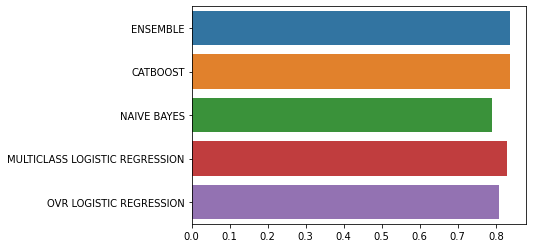

In [165]:
acc_list = [accuracy_ensemble, Catboost_acc, nb_acc, acc_log_reg, acc]
names = ['ENSEMBLE','CATBOOST','NAIVE BAYES','MULTICLASS LOGISTIC REGRESSION','OVR LOGISTIC REGRESSION']

sns.barplot(x=acc_list,y=names)




In [182]:
df = pd.DataFrame(acc_list, index=names)
df.rename(columns={0:'accuracy'}, inplace=True)
df.T


ENSEMBLE  ...  OVR LOGISTIC REGRESSION
accuracy     0.837  ...                   0.8075

[1 rows x 5 columns]

Catboost still has a better performance over all

# **2) REAL CASE STUDY APPLICATION**

**IN THIS PART WE USED EARTH ENGINE API'S TO SCRAPE AND COLLECT A NEW A DATASET**

# Now let's try to apply this to a real case 

In [32]:
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=a9gETeTOjyjI4x8sXT4zePRZFn_N9vqxp4U7SK9SiVo&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g4to66zS-fSHcgO7lb3FqZScwS5rOPHx1G7NOyOwVZxfb177PIe8lg

Successfully saved authorization token.


In [33]:
ee.Initialize()

In [34]:
# Access a specific image
image = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_044034_20140318'); #Landsat 8 image, with Top of Atmosphere processing, on 2014/03/18

# Access a collection
collection = 'LANDSAT/LE07/C01/T1' #Landsat 7 raw images collection

In [61]:
#Landsat_composite in Dresden area
area_dresden = list([(13.6, 50.96), (13.9, 50.96), (13.9, 51.12), (13.6, 51.12), (13.6, 50.96)])
area_dresden = ee.Geometry.Polygon(area_dresden)
time_range_dresden = ['2002-07-28', '2002-08-05']

collection_dresden = ('LANDSAT/LE07/C01/T1')
print(type(area_dresden))


<class 'ee.geometry.Geometry'>


In [60]:

def obtain_image_landsat_composite(collection, time_range, area):

    """ Selection of Landsat cloud-free composites in the Earth Engine library

    Parameters:
        collection (): name of the collection
        time_range (['YYYY-MT-DY','YYYY-MT-DY']): must be inside the available data
        area (ee.geometry.Geometry): area of interest

    Returns:
        image_composite (ee.image.Image)
     """
    collection = ee.ImageCollection(collection)

    ## Filter by time range and location
    collection_time = collection.filterDate(time_range[0], time_range[1])
    image_area = collection_time.filterBounds(area)
    image_composite = ee.Algorithms.Landsat.simpleComposite(image_area, 75, 3)
    return image_composite

def obtain_image_median(collection, time_range, area):

    """ Selection of median from a collection of images in the Earth Engine library

    Parameters:
        collection (): name of the collection
        time_range (['YYYY-MT-DY','YYYY-MT-DY']): must be inside the available data
        area (ee.geometry.Geometry): area of interest

    Returns:
        image_median (ee.image.Image)
     """
    collection = ee.ImageCollection(collection)

    ## Filter by time range and location
    collection_time = collection.filterDate(time_range[0], time_range[1])
    image_area = collection_time.filterBounds(area)
    image_median = image_area.median()
    return image_median

def obtain_image_sentinel(collection, time_range, area):

    """ Selection of median, cloud-free image from a collection of images in the Sentinel 2 dataset

    Parameters:
        collection (): name of the collection
        time_range (['YYYY-MT-DY','YYYY-MT-DY']): must be inside the available data
        area (ee.geometry.Geometry): area of interest

    Returns:
        sentinel_median (ee.image.Image)
     """
#First, method to remove cloud from the image
    def maskclouds(image):
        band_qa = image.select('QA60')
        cloud_mask = ee.Number(2).pow(10).int()
        cirrus_mask = ee.Number(2).pow(11).int()
        mask = band_qa.bitwiseAnd(cloud_mask).eq(0) and(
            band_qa.bitwiseAnd(cirrus_mask).eq(0))
        return image.updateMask(mask).divide(10000)

    sentinel_filtered = (ee.ImageCollection(collection).
                         filterBounds(area).
                         filterDate(time_range[0], time_range[1]).
                         filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)).
                         map(maskclouds))

    sentinel_median = sentinel_filtered.median()
    return sentinel_median

In [58]:
#Application to dresden images
composite_dresden = obtain_image_landsat_composite(collection_dresden, time_range_dresden, area_dresden)

In [41]:
def get_region(geom):
  
    """Get the region of a given geometry, needed for exporting tasks.

    Parameters:
        geom (ee.Geometry, ee.Feature, ee.Image): region of interest

    Returns:
        region (list)
    """
    if isinstance(geom, ee.Geometry):
        region = geom.getInfo()["coordinates"]
    elif isinstance(geom, ee.Feature, ee.Image):
        region = geom.geometry().getInfo()["coordinates"]
    elif isinstance(geom, list):
        condition = all([isinstance(item) == list for item in geom])
        if condition:
            region = geom
    return region


region_dresden = get_region(area_dresden)

In [59]:
def get_url(name, image, scale, region):

    path = image.getDownloadURL({
        'name':(name),
        'scale': scale,
        'region':(region)
        })

    webbrowser.open_new_tab(path)
    return path



url_dresden = get_url('dresden', composite_dresden, 30, region_dresden)

print(url_dresden)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/806f7e9f7e778a37b628858d0edf4593-31a333ab993887cdc4d5f45c1a42fe31:getPixels


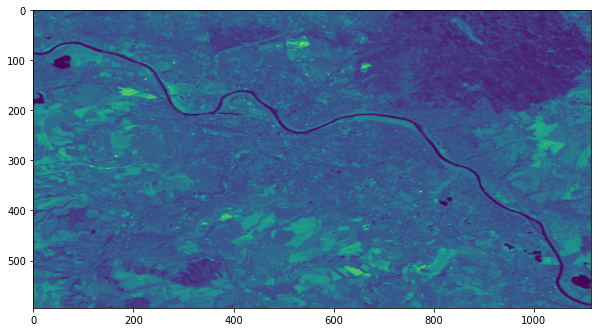

In [56]:
#let's see how is one image 

image_dresdenB5 = imread('dresden.B5.tif')
plt.figure(figsize=(10, 10))
plt.imshow(image_dresdenB5)

#im = Image.open('dresden.B5.tif')
#im

In [10]:
#now we we open the immage as an array
a = tiff.imread('dresden.B1.tif')
a

array([[27, 26, 25, ..., 33, 32, 32],
       [30, 27, 25, ..., 29, 27, 27],
       [33, 30, 26, ..., 24, 23, 23],
       ...,
       [32, 28, 28, ..., 26, 26, 26],
       [31, 26, 26, ..., 24, 24, 25],
       [30, 25, 25, ..., 25, 25, 26]], dtype=uint8)

In [11]:
import matplotlib.pyplot as plt

In [12]:
image_dresdenB2 = tiff.imread('dresden.B2.tif') #spectral band 4
image_dresdenB3 = tiff.imread('dresden.B3.tif') #spectral band 2
image_dresdenB4 = tiff.imread('dresden.B4.tif') #spectral band 6
image_dresdenB6 = tiff.imread('dresden.B6_VCID_2.tif') #spectral band 3


In [14]:
image_dresdenB4 = image_dresdenB4.astype(str)
image_dresdenB2 = image_dresdenB2.astype(str)
image_dresdenB6 = image_dresdenB6.astype(str)
image_dresdenB3 = image_dresdenB3.astype(str)

In [15]:
final_pixels = []
for i in range(595):
    for j in range(1115):
        final_pixels.append(image_dresdenB4[i][j]+' '+image_dresdenB2[i][j]+' '+image_dresdenB6[i][j]+' '+image_dresdenB3[i][j])

In [16]:
final_pixels = np.array(final_pixels)

In [17]:
pixels = np.reshape(final_pixels,(595,1115))

In [18]:
sliced_pixels  = pixels[100:182, 100:200]
sliced_pixels

array([['55 28 202 32', '58 31 203 34', '56 33 204 37', ...,
        '24 28 193 24', '24 29 193 23', '26 28 193 24'],
       ['52 27 202 29', '55 32 203 35', '57 34 204 37', ...,
        '27 28 192 24', '25 28 192 24', '24 28 192 23'],
       ['56 28 202 29', '58 32 203 34', '58 33 204 36', ...,
        '34 29 193 23', '25 29 193 24', '24 28 192 24'],
       ...,
       ['53 29 198 35', '52 29 198 35', '52 29 198 35', ...,
        '49 35 203 36', '50 35 203 36', '50 35 203 36'],
       ['54 29 199 35', '54 28 199 35', '54 28 199 35', ...,
        '54 36 203 38', '55 38 203 40', '55 38 203 40'],
       ['53 29 199 35', '53 28 199 35', '53 28 199 35', ...,
        '57 29 204 28', '54 28 203 27', '54 28 203 27']], dtype='<U15')

In [19]:
Last_dataset = []

for el in sliced_pixels:
  for p  in el:
    l = [int(s) for s in p.split(' ')]
    Last_dataset.append(l)


In [21]:
Last_dataset[0]

[55, 28, 202, 32]

# **3) CLASSIFICATION ON OUR MSS IMAGE, FROM LANDSAT-8 MISSION**

Best classifier is Catboost, let's apply it

In [133]:
final_prediction = catboost.predict(Last_dataset) #calssifier application

In [134]:
final_prediction = final_prediction.T[0] #reshape
final_prediction = final_prediction.tolist() #taking list format


# So this are the results of the application of our trained model to our real case

In [152]:
pred_labels = list(set(list(final_prediction)))

histogram = []
for l in pred_labels:
  histogram.append(final_prediction.count(l))
print(histogram)

[136, 2231, 203, 12, 5342, 276]


In [155]:
prob_result = histogram / np.sum(histogram)
prob_result

array([0.01658537, 0.27207317, 0.0247561 , 0.00146341, 0.65146341,
       0.03365854])

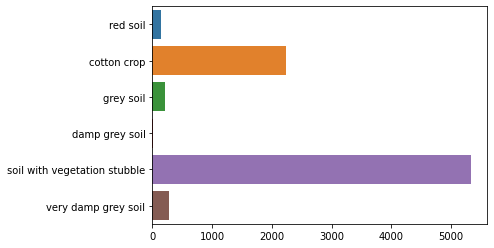

In [161]:
labels_name = ['red soil','cotton crop','grey soil','damp grey soil','soil with vegetation stubble','very damp grey soil']

sns.barplot(x=histogram,y=labels_name)

**NB: damp grey soil, due to a very low number of classifications is not printable on the bar plot**